# Predicting commute times

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

%matplotlib inline

Using TensorFlow backend.


### Raw data

In [37]:
# Read in the raw data -- 5000 rows, no parameters changed
data = pd.read_csv("../data/commute_times.csv")

data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day,commute_type,commute_time
0,0.824392,0.475742,0.933873,-0.292262,8.856115,TRAIN,1.028704
1,0.795889,0.075121,0.240722,0.465027,9.058129,BIKE,4.634294
2,-0.902398,0.124019,0.666059,-0.260070,8.524607,CAR,6.491592
3,0.496755,-0.747187,0.161702,0.385728,9.676583,BUS,5.415297
4,-0.085848,-0.914451,-0.058177,0.278478,14.784042,BUS,1.499639


### Generate some basic features

This is just to mess around with what I expect Susan might create.

In [3]:
# Create some categorical variables from commute_type
data = pd.concat([data, pd.get_dummies(data["commute_type"])], axis=1).drop(["commute_type"], axis=1)

# Add L2 norm -- it "makes sense" and you might well create this if you 
# didn't know how the data was generated;
# the L1 norm would just be a collinearity mess
data.loc[:, "distance"] = np.sqrt(
    (data["destination_latitude"] - data["source_latitude"])**2 +
    (data["destination_longitude"] - data["source_longitude"])**2
)

data.head()

,source_latitude,source_longitude,destination_latitude,destination_longitude,time_of_day,commute_time,BIKE,BUS,CAR,TRAIN,WALK,distance
0,0.824392,0.475742,0.933873,-0.292262,8.856115,1.028704,0,0,0,1,0,0.775768
1,0.795889,0.075121,0.240722,0.465027,9.058129,4.634294,1,0,0,0,0,0.678408
2,-0.902398,0.124019,0.666059,-0.260070,8.524607,6.491592,0,0,1,0,0,1.614800
3,0.496755,-0.747187,0.161702,0.385728,9.676583,5.415297,0,1,0,0,0,1.181421
4,-0.085848,-0.914451,-0.058177,0.278478,14.784042,1.499639,0,1,0,0,0,1.193250


### Create train and test datasets and scale the features for neural net use

In [4]:
np.random.seed(0)

# Create X and y
X = data.drop(["commute_time"], axis=1)
y = data["commute_time"]

# Scale features
X = StandardScaler().fit_transform(X)

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Linear regression

In [5]:
# Train a linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Calculate its RMSE
lr_rmse = np.sqrt(np.mean( (lr.predict(X_test) - y_test)**2 ) )
print("RMSE linear regression : {:.2f}".format(lr_rmse))
print("( R^2 : {:.3f} )".format(lr.score(X_test, y_test)))

RMSE linear regression : 5.59
( R^2 : 0.333 )


### Neural net

RMSE neural network : 4.76


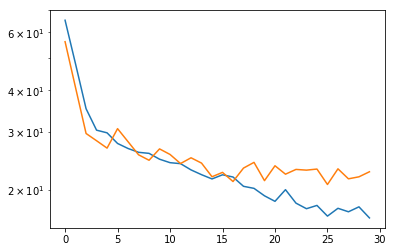

In [6]:
# Simple neural net : three hidden layers, Adam optimiser

model = Sequential()

model.add(Dense(512, activation="relu", input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam")

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=30,
    verbose=0,
    validation_data=(X_test, y_test)
)

# Calculate RMSE
nn_rmse = np.sqrt(model.evaluate(X_test, y_test, verbose=0))
print("RMSE neural network : {:.2f}".format(nn_rmse))

plt.semilogy(history.history["loss"])
plt.semilogy(history.history["val_loss"])

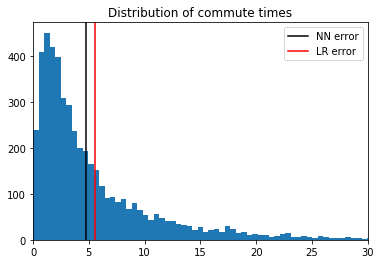

In [38]:
plt.hist(data["commute_time"], bins=200)
plt.axvline(nn_rmse, c="k")
plt.axvline(lr_rmse, c="r")
plt.xlim(0, 30)
plt.title("Distribution of commute times")
plt.legend(["NN error", "LR error"])

### TL; DR :

RMSE of 4.76 for neural nets and 5.59 for linear regression. Compared with the distribution of commute times, it's "realistic", sure, but not great or encouraging. I'm going to keep tweaking the net, and we might have more features, but I think we can make this a little easier -- not much, just a touch.

### Ignore -- grid-searching NNs for posterity

In [30]:
layers = [1, 2, 3, 4, 5, 6, 7]
layer_sizes = [64, 128, 256, 512]
reg_type = ["bn", "do", None]

np.random.seed(0)

def score_nn(layers, layer_size, reg):
    
    np.random.seed(0)
    
    model = Sequential()
    
    model.add(Dense(layer_size, activation="relu", input_dim=X_train.shape[1]))
    if reg is not None:
        if reg == "bn":
            model.add(BatchNormalization())
        elif reg == "do": 
            model.add(Dropout(0.2))
    
    for _ in range(layers-1):
        model.add(Dense(layer_size, activation="relu"))
        if reg is not None:
            if reg == "bn":
                model.add(BatchNormalization())
            elif reg == "do": 
                model.add(Dropout(0.2))
                
    model.add(Dense(1, activation="linear"))
    
    np.random.seed(0)
    model.compile(loss="mse", optimizer="adam")
    np.random.seed(0)

    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=30,
        verbose=0,
        validation_data=(X_test, y_test)
    )

    # Calculate RMSE
    nn_rmse = np.sqrt(model.evaluate(X_test, y_test, verbose=0))

    return nn_rmse

In [ ]:
from tqdm import tqdm

results_bn = np.zeros((len(layers), len(layer_sizes)))
results_do = np.zeros((len(layers), len(layer_sizes)))
results_none = np.zeros((len(layers), len(layer_sizes)))

for i, layer in enumerate(tqdm(layers, desc="BN")):
    for j, layer_size in enumerate(layer_sizes):
        results_bn[i, j] = score_nn(layer, layer_size, "bn")
        
for i, layer in enumerate(tqdm(layers, desc="DO")):
    for j, layer_size in enumerate(layer_sizes):
        results_bn[i, j] = score_nn(layer, layer_size, "do")
        
for i, layer in enumerate(tqdm(layers, desc="None")):
    for j, layer_size in enumerate(layer_sizes):
        results_bn[i, j] = score_nn(layer, layer_size, None)

DO:  43%|████▎     | 3/7 [05:18<07:02, 105.68s/it]

In [33]:
results_bn

5.091942824612819